### 1. IMPORT LIBRARIES

In [1]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

### 2. BUILD TRAIN DATAFRAME FROM FOLDERS


In [2]:
train_data_dir = 'dataset/training'

filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    f_path = os.path.join(train_data_dir , fold)
    if os.path.isdir(f_path):
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path , file))
            labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'labels')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

### 3. BUILD TEST DATAFRAME FROM FOLDERS


In [3]:
test_data_dir = 'dataset/testing'

filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    f_path = os.path.join(test_data_dir , fold)
    if os.path.isdir(f_path):
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path , file))
            labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'labels')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

### 4. SPLIT TEST INTO VALIDATION + TEST

In [4]:
# valid, test = train_test_split(test_df, train_size = 0.5, shuffle = True, random_state= 42)
valid , test = train_test_split(test_df , test_size = 0.5 , shuffle = True , stratify = test_df['labels'] , random_state = 42)

### 5. CREATE DATA GENERATORS

In [5]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


### 6. VISUALIZE ONE TRAINING BATCH


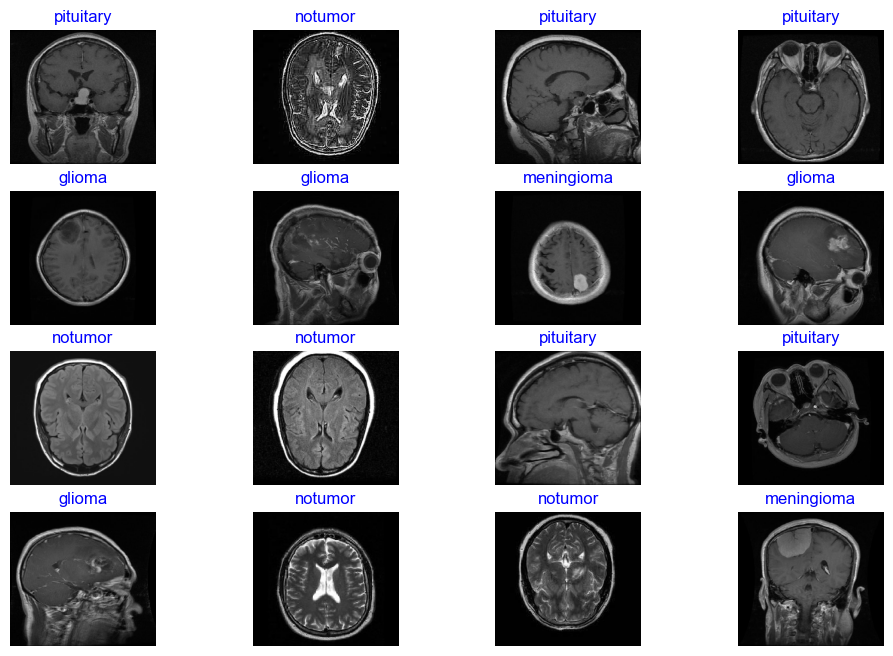

In [6]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize = (12 , 8))
for i in range(16):
    plt.subplot(4 , 4 , i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

### 7. BUILD TRANSFER LEARNING MODEL (EfficientNetV2B0)

In [7]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False , weights = 'imagenet',
    input_shape = img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

### 8. TRAIN MODEL

In [9]:
Epochs = 10

history = model.fit(
    train_gen,
    epochs = Epochs,
    verbose = 1,
    validation_data = valid_gen,
    shuffle = True
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.6971 - loss: 1.6029 - val_accuracy: 0.7252 - val_loss: 1.3361
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.7129 - loss: 1.2912 - val_accuracy: 0.7710 - val_loss: 1.0702
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.7465 - loss: 1.0912 - val_accuracy: 0.7695 - val_loss: 0.9255
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.7890 - loss: 0.9620 - val_accuracy: 0.8916 - val_loss: 0.8001
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8687 - loss: 0.8602 - val_accuracy: 0.9557 - val_loss: 0.6783
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.9139 - loss: 0.7590 - val_accuracy: 0.9740 - val_loss: 0.5902
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.9207 - loss: 0.6857 - val_accuracy: 0.9740 - val_loss: 0.5235
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.9363 - loss: 0.6221 - val_accu

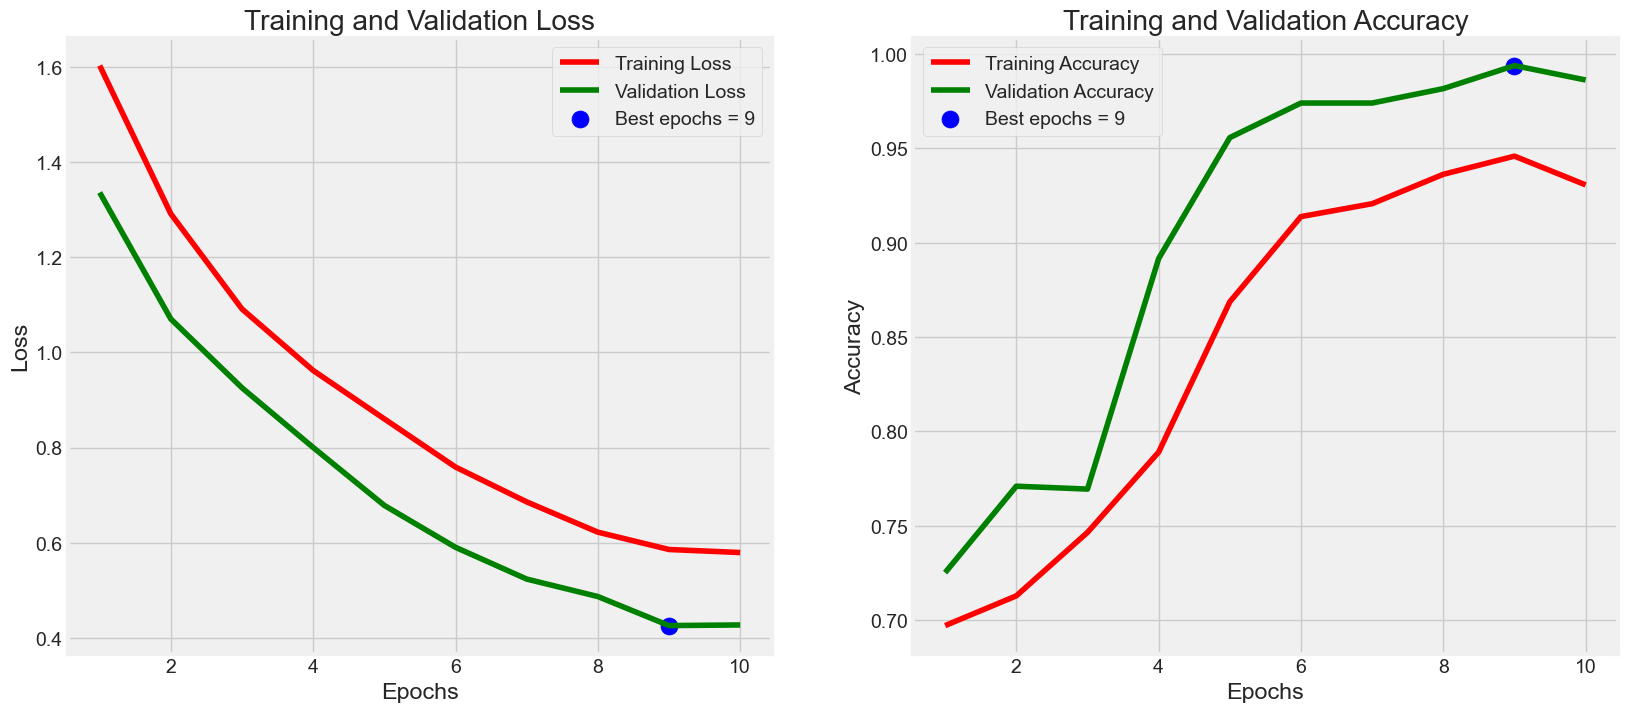

In [10]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [11]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.9961 - loss: 0.4034
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.9844 - loss: 0.4259
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.9844 - loss: 0.4155
Train Loss:  0.4034154713153839
Train Accuracy:  0.99609375
--------------------
Validation Loss:  0.4258877635002136
Validation Accuracy:  0.984375
--------------------
Test Loss:  0.4155399203300476
Test Accuracy:  0.984375


In [12]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step


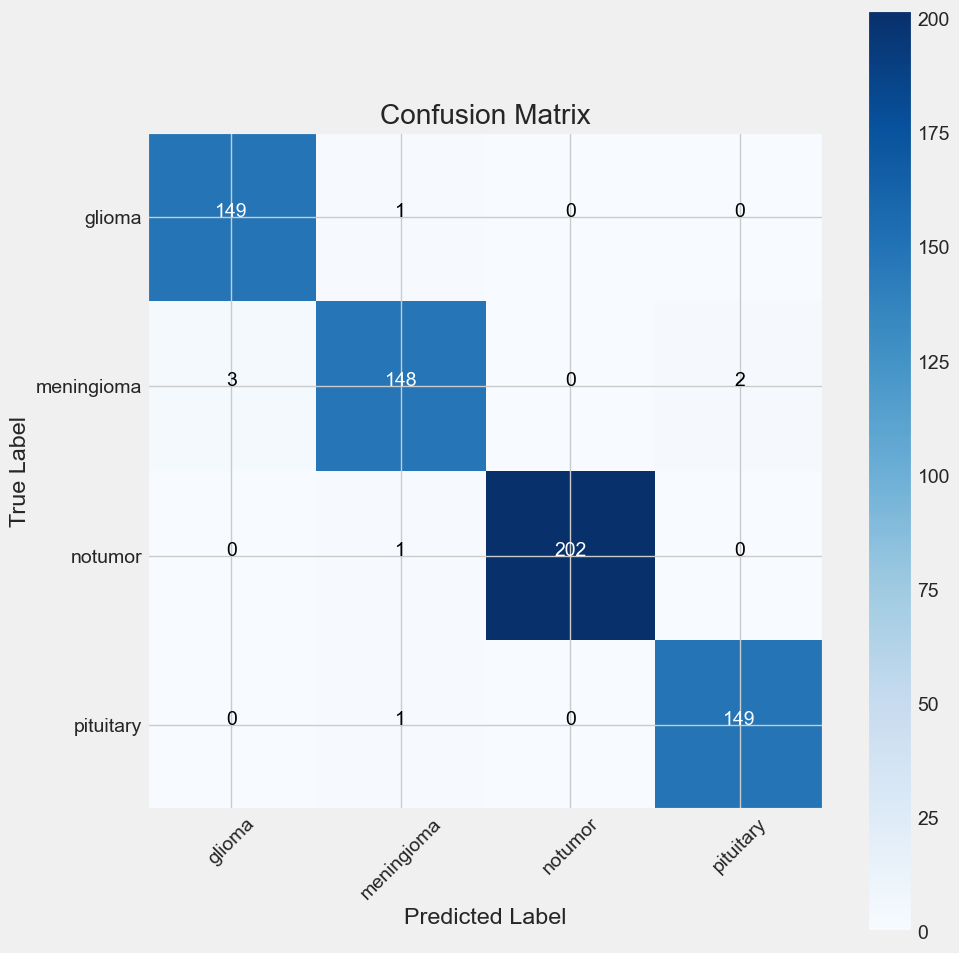

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [14]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       150
  meningioma       0.98      0.97      0.97       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.99      0.99      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [15]:
model.save("model.h5")

In [16]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [17]:
model = load_model('model.h5', compile=False)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
gambar = tf.keras.preprocessing.image.load_img('./dataset/Testing/glioma/Te-glTr_0000.jpg', target_size=img_size)

In [22]:
input_arr = tf.keras.preprocessing.image.img_to_array(gambar)

In [23]:
input_arr = np.array([input_arr])
prediksi = model.predict(input_arr)
predicted_class = np.argmax(prediksi, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [24]:
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [25]:
print(predicted_class)

[0]


In [26]:
names = [classes[i] for i in predicted_class]
print(names)

['glioma']
